In [101]:
import os
import pathlib
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
from multiprocessing import cpu_count

import numpy as np
import torch
import torchvision.transforms as TF
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d
from PIL import Image
from tqdm import tqdm


from data.dataloader import get_dataloader
from PIL import Image
import torchvision.transforms as transforms
from data.train import RandomSizedCrop

import random
import math
from torchvision.transforms import Scale, CenterCrop, ToPILImage
from models.standard import *
from train import mask_gen

import cv2
from matplotlib.pyplot import imshow

In [12]:
class ImagesPathDataset(torch.utils.data.Dataset):
    def __init__(self, files, transforms=None):
        self.files = files
        self.transforms = transforms

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        path = self.files[i]
        img = Image.open(path).convert('RGB')
        if self.transforms is not None:
            img = self.transforms(img)
        return img

In [4]:
def get_activations(files, model, batch_size=50, dims=2048, device='cpu'):
    """Calculates the activations of the pool_3 layer for all images.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : Batch size of images for the model to process at once.
                     Make sure that the number of samples is a multiple of
                     the batch size, otherwise some samples are ignored. This
                     behavior is retained to match the original FID score
                     implementation.
    -- dims        : Dimensionality of features returned by Inception
    -- device      : Device to run calculations
    Returns:
    -- A numpy array of dimension (num images, dims) that contains the
       activations of the given tensor when feeding inception with the
       query tensor.
    """
    model.eval()

    if batch_size > len(files):
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = len(files)

    ds = ImagesPathDataset(files, transforms=TF.ToTensor())
    dl = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                                     drop_last=False, num_workers=cpu_count())

    pred_arr = np.empty((len(files), dims))

    start_idx = 0

    for batch in tqdm(dl):
        batch = batch.to(device)

        with torch.no_grad():
            pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred = pred.squeeze(3).squeeze(2).cpu().numpy()

        pred_arr[start_idx:start_idx + pred.shape[0]] = pred

        start_idx = start_idx + pred.shape[0]

    return pred_arr

In [3]:
def calculate_activation_statistics(files, model, batch_size=50, dims=2048, device='cpu'):
    """Calculation of the statistics used by the FID.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : The images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size
                     depends on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- device      : Device to run calculations
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the inception model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the inception model.
    """
    act = get_activations(files, model, batch_size, dims, device)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [15]:
def _compute_statistics_of_path(path, model, batch_size, dims, device):
    
    path = pathlib.Path(path)
    files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
    m, s = calculate_activation_statistics(files, model, batch_size,
                                           dims, device)

    return m, s


In [9]:
from pytorch_fid.inception import InceptionV3
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]

model = InceptionV3([block_idx])

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /home/jtkim/.cache/torch/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:35<00:00, 2.73MB/s]


In [20]:
mu, sigma = _compute_statistics_of_path('data/yumi/train/color/', model, batch_size=50, dims=2048, device='cpu')

  0%|          | 0/162 [00:00<?, ?it/s]

[PosixPath('data/yumi/train/color/5826.jpg'), PosixPath('data/yumi/train/color/142.jpg'), PosixPath('data/yumi/train/color/7807.jpg'), PosixPath('data/yumi/train/color/7996.jpg'), PosixPath('data/yumi/train/color/7025.jpg'), PosixPath('data/yumi/train/color/3858.jpg'), PosixPath('data/yumi/train/color/1543.jpg'), PosixPath('data/yumi/train/color/3961.jpg'), PosixPath('data/yumi/train/color/1127.jpg'), PosixPath('data/yumi/train/color/7488.jpg'), PosixPath('data/yumi/train/color/4094.jpg'), PosixPath('data/yumi/train/color/2697.jpg'), PosixPath('data/yumi/train/color/2591.jpg'), PosixPath('data/yumi/train/color/420.jpg'), PosixPath('data/yumi/train/color/7921.jpg'), PosixPath('data/yumi/train/color/1698.jpg'), PosixPath('data/yumi/train/color/5552.jpg'), PosixPath('data/yumi/train/color/154.jpg'), PosixPath('data/yumi/train/color/546.jpg'), PosixPath('data/yumi/train/color/4026.jpg'), PosixPath('data/yumi/train/color/2883.jpg'), PosixPath('data/yumi/train/color/3169.jpg'), PosixPath('da

100%|██████████| 162/162 [08:38<00:00,  3.20s/it]


In [24]:
target_npz = {'mu':mu, 'sigma':sigma}

In [41]:
np.savez('resources/fid_stats_color', mu=mu, sigma=sigma)

In [42]:
f = np.load('resources/fid_stats_color.npz')
#m1, s1 = f['mu'][:], f['sigma'][:]

In [45]:
f['mu'][:]

array([0.90006071, 0.11522567, 0.3532578 , ..., 0.42136322, 0.33980848,
       0.21900649])

In [39]:
m1, s1 = f['mu'][:], f['sigma'][:]

KeyError: 'mu is not a file in the archive'

In [92]:
weight = torch.load('experiments/origin/ckpt_best.pth.tar')

In [93]:
from easydict import EasyDict
import yaml

with open('experiments/origin/config.yaml') as f:
    config = EasyDict(yaml.load(f))

netG = NetG(ngf=config.ngf)
netI = NetI()

/home/jtkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """


In [94]:
netG.load_state_dict(weight['state_dictG'])
netI.load_state_dict(weight['state_dictI'])

<All keys matched successfully>

In [95]:
val_loader = get_dataloader('yumi', 'val', batch_size=32)

In [109]:
import scipy.stats as stats

def mask_gen():
    maskS = 256 // 4
    mu, sigma = 1, 0.005
    X = stats.truncnorm((0 - mu) / sigma, (1 - mu) / sigma, loc=mu, scale=sigma)
    mask1 = torch.cat(
        [torch.rand(1, 1, maskS, maskS).ge(X.rvs(1)[0]).float() for _ in range(32 // 2)], 0)
    mask2 = torch.cat([torch.zeros(1, 1, maskS, maskS).float() for _ in range(32 // 2)], 0)
    mask = torch.cat([mask1, mask2], 0)

    return mask

mask = mask_gen()
           
hint = torch.cat((batch[1] * mask, mask), 1)

In [110]:
hint = torch.cat((batch[1] * mask, mask), 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


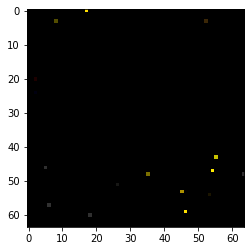

In [118]:
imshow((batch[1]*mask)[0].numpy().transpose(1, 2, 0))

In [105]:
for batch in val_loader:
    real_sim = batch[-1]
    mask = mask_gen()
           
    hint = torch.cat((batch[1] * mask, mask), 1)
    #zhint = torch.zeros(real_sim.shape[0], 4, 256 // 4, 256 // 4).float()
    with torch.no_grad():
        feat_sim = netI(real_sim)
        fake_cim = netG(real_sim, hint, feat_sim).squeeze()
        print(fake_cim)
        break

/home/jtkim/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:219: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/home/jtkim/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:219: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


tensor([[[[ 0.0612,  0.0889,  0.1039,  ...,  0.1294,  0.1113, -0.0061],
          [ 0.0893,  0.1253,  0.1320,  ...,  0.2924,  0.2595,  0.2107],
          [ 0.1100,  0.1418,  0.1423,  ...,  0.2796,  0.2351,  0.1490],
          ...,
          [ 0.1917,  0.3123,  0.2863,  ...,  0.3035,  0.2478,  0.1714],
          [ 0.1792,  0.3174,  0.3019,  ...,  0.2927,  0.2637,  0.2083],
          [ 0.1309,  0.2288,  0.2313,  ...,  0.2368,  0.2363,  0.1894]],

         [[ 0.0379,  0.1326,  0.1502,  ...,  0.2438,  0.2382,  0.2022],
          [ 0.1360,  0.2347,  0.2286,  ...,  0.4580,  0.4310,  0.3421],
          [ 0.1177,  0.1910,  0.1924,  ...,  0.4111,  0.3522,  0.3216],
          ...,
          [ 0.2448,  0.4556,  0.4119,  ...,  0.4319,  0.3981,  0.3391],
          [ 0.2794,  0.4614,  0.4493,  ...,  0.4692,  0.4059,  0.3732],
          [ 0.1714,  0.2866,  0.3059,  ...,  0.3096,  0.3128,  0.2255]],

         [[ 0.1276,  0.1635,  0.1651,  ...,  0.2425,  0.2639,  0.1617],
          [ 0.2236,  0.2300,  

In [97]:
fake_cim[0].numpy().shape

(3, 256, 256)

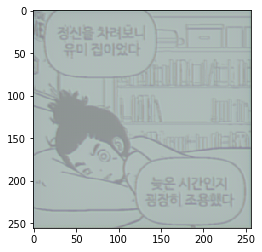

In [123]:
g = fake_cim[0].detach().mul(0.5).add(0.5)
g = g.numpy().transpose(1, 2, 0)

imshow(g)

In [125]:
batch[0][0]

tensor([[[0.3804, 0.1608, 0.3765,  ..., 0.3333, 0.3294, 0.3255],
         [0.2824, 0.0627, 0.3843,  ..., 0.3569, 0.3529, 0.3490],
         [0.2118, 0.0549, 0.3490,  ..., 0.3451, 0.3412, 0.3373],
         ...,
         [0.5843, 0.5843, 0.5843,  ..., 0.5843, 0.5843, 0.5843],
         [0.5843, 0.5843, 0.5843,  ..., 0.5843, 0.5843, 0.5843],
         [0.5843, 0.5843, 0.5843,  ..., 0.5843, 0.5843, 0.5843]],

        [[0.4471, 0.2118, 0.3804,  ..., 0.4824, 0.4784, 0.4745],
         [0.3490, 0.1059, 0.3922,  ..., 0.5059, 0.5020, 0.4980],
         [0.2627, 0.0941, 0.3529,  ..., 0.4824, 0.4784, 0.4745],
         ...,
         [0.5843, 0.5843, 0.5843,  ..., 0.5843, 0.5843, 0.5843],
         [0.5843, 0.5843, 0.5843,  ..., 0.5843, 0.5843, 0.5843],
         [0.5843, 0.5843, 0.5843,  ..., 0.5843, 0.5843, 0.5843]],

        [[0.3725, 0.1412, 0.3255,  ..., 0.4941, 0.4902, 0.4863],
         [0.2784, 0.0431, 0.3412,  ..., 0.5176, 0.5137, 0.5098],
         [0.2235, 0.0588, 0.3294,  ..., 0.4980, 0.4941, 0.

In [124]:
g

array([[[0.53057885, 0.5189322 , 0.5637766 ],
        [0.54447436, 0.566291  , 0.5817448 ],
        [0.5519629 , 0.5751012 , 0.58254385],
        ...,
        [0.56469285, 0.6218829 , 0.62124944],
        [0.5556688 , 0.6191105 , 0.6319742 ],
        [0.49694481, 0.6011077 , 0.58087164]],

       [[0.5446562 , 0.56801224, 0.6118103 ],
        [0.562629  , 0.61732584, 0.61499417],
        [0.56602347, 0.61428857, 0.6207765 ],
        ...,
        [0.64620405, 0.72899276, 0.7059776 ],
        [0.62972856, 0.715482  , 0.700646  ],
        [0.6053379 , 0.67104775, 0.62733257]],

       [[0.5549853 , 0.55883974, 0.6073859 ],
        [0.57089865, 0.59551847, 0.5959199 ],
        [0.57115984, 0.59621006, 0.6028638 ],
        ...,
        [0.6398227 , 0.705575  , 0.68418497],
        [0.6175602 , 0.6761242 , 0.70767534],
        [0.57449204, 0.6607803 , 0.61856216]],

       ...,

       [[0.59585273, 0.6223877 , 0.6710095 ],
        [0.6561351 , 0.7277995 , 0.73512036],
        [0.64315623, 0

In [69]:
batch[0].shape

torch.Size([32, 3, 256, 256])

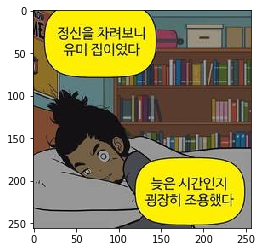

In [70]:
imshow(batch[0][0].numpy().transpose(1, 2, 0))

In [76]:
batch[0][0].var()

tensor(0.0853)

In [77]:
fake_cim.var()

tensor(0.0074)

In [82]:
image = cv2.imread('data/yumi/train/color/5826.jpg')
image2 = Image.open('data/yumi/train/color/5826.jpg').convert('RGB')

In [89]:
cv2.cvtColor(image, cv2.COLOR_BGR2RGB)[0]

array([[246,  95, 146],
       [240,  98, 146],
       [230, 103, 146],
       [222, 107, 146],
       [218, 110, 146],
       [220, 108, 146],
       [230, 103, 146],
       [241,  97, 146],
       [255, 111, 167],
       [237,  68, 125],
       [238,  79, 133],
       [240, 107, 152],
       [211, 120, 151],
       [185, 137, 153],
       [ 78,  69,  72],
       [ 14,  25,  21],
       [225, 227, 226],
       [236, 236, 236],
       [247, 247, 247],
       [252, 252, 252],
       [251, 251, 251],
       [249, 249, 249],
       [250, 250, 250],
       [253, 253, 253],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254

In [88]:
np.array(image2)[0]

array([[248,  94, 146],
       [241,  97, 146],
       [229, 104, 146],
       [219, 109, 146],
       [213, 112, 146],
       [216, 110, 146],
       [227, 105, 146],
       [244,  96, 146],
       [255, 110, 167],
       [244,  64, 125],
       [247,  75, 133],
       [246, 104, 152],
       [215, 118, 151],
       [184, 137, 153],
       [ 73,  71,  72],
       [  6,  29,  21],
       [226, 226, 226],
       [236, 236, 236],
       [247, 247, 247],
       [252, 252, 252],
       [251, 251, 251],
       [249, 249, 249],
       [250, 250, 250],
       [253, 253, 253],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254, 254],
       [254, 254

In [91]:
from torchvision.transforms import RandomSizedCrop

In [ ]:
RandomSizedCrop()